In [198]:
# Setup: imports, reproducibility, plotting defaults
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)  # reproducible

X shape: (1797, 64), y shape: (1797,), classes: [0 1 2 3 4 5 6 7 8 9]


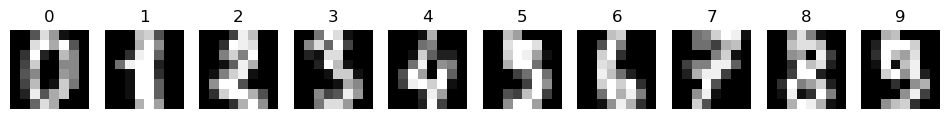

In [199]:
# Load and inspect the digits dataset
digits = load_digits()
X = digits.data.astype(np.float64)   # shape: (n_samples, 64)
y = digits.target.astype(np.int64)   # shape: (n_samples,)

print(f"X shape: {X.shape}, y shape: {y.shape}, classes: {np.unique(y)}")

# Visual sanity check
fig, axes = plt.subplots(1, 10, figsize=(12, 2.5))
for ax, i in zip(axes, range(10)):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(str(y[i]))
    ax.axis('off')
plt.show()

In [200]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size = 0.5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [203]:
class myMLPClassifier: 
    import numpy as np 
    def __init__(self, layer_size = [64, 128, 64, 10], activation = 'relu', l2 = 0, momentum = 0):
        self.layer_size = layer_size
        self.activation = activation
        self.l2 = l2 
        self.momentum = momentum 

        ###### raise errors for argument mismatches ###########
        if not activation in ['relu', 'tanh', 'sigmoid']:
            raise ValueError("activation function must be either 'relu', 'tanh', or 'sigmoid'")
        ########################################################

        ##### initialize weights and bias matrices based on activation function ###########
        def Xavier(n,m): 
            lower, upper = -(1.0 / np.sqrt(n)), (1.0 / np.sqrt(n))
            numbers = np.random.rand(5000)
            scaled = lower + numbers * (upper - lower)
            weights = np.random.choice(scaled, n*m, replace = True)
            return weights.reshape(n,m)

        def He(n,m): 
            std = np.sqrt(2.0 / n)
            numbers = np.random.randn(1000)
            scaled = numbers * std
            weights = np.random.choice(scaled, n*m, replace = True)
            return weights.reshape(n,m) 
            
        if activation in ['sigmoid', 'tanh']:
            self.W = [Xavier(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)] # Xavier weight initialization
            self.b = [np.zeros((1, layer_size[i+1])) for i in range(len(layer_size)-1)] # zero initial bias 
        else: 
            self.W = [He(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)] # He weight initialization
            self.b = [np.zeros((1, layer_size[i+1])) for i in range(len(layer_size)-1)] # zero initial bias 
        ####################################################################################
        self.L = len(self.W)
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]

    def forward(self, X):
        ##### define activation functions ################
        def relu(x):
            return np.maximum(0,x)
        def tanh(x):
            return np.tanh(x)
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        ##################################################
        L = self.L
        Z = X
        zs = [] # pre-activations
        hs = [X]
        
        # fully-forward propogation with relu activation 
        if self.activation == 'relu':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = relu(Z)
                hs.append(Z)
        if self.activation == 'tanh':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = tanh(Z)
                hs.append(Z)
        if self.activation == 'sigmoid':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = sigmoid(Z)
                hs.append(Z)
                
        def stable_softmax(Z):
            return [np.exp(Z[i] - np.max(Z[i])) / np.sum(np.exp(Z[i] - np.max(Z[i]))) for i in range(Z.shape[0])]

        return stable_softmax(Z), Z, zs, hs
        
    def loss_and_grads(self, X, Y):
        p, _, zs, hs = self.forward(X)
        p_true = [p[i][j] for i,j in enumerate(Y)]
        p_clip = np.clip(p_true, 1e-12, 1.0) # for numerical stability
        cross_entropy_loss = -np.mean(np.log(p_clip))
        
        ###### CE + L2 Regularization #########################################
        cross_entropy_loss = -np.mean(np.log(p_clip))
        l2reg_penalty = self.l2*np.sum([np.sum(self.W[i]**2) for i in range(len(self.W))])
        loss = cross_entropy_loss + l2reg_penalty
        #########################################################################
        grad_logits = p.copy()
        for i,j in enumerate(Y):
            grad_logits[i][j] -= 1
        
        return loss, grad_logits, zs, hs
        
    def backward(self,X,Y, learning_rate = 1e-3):
        ##### define activation function derivatives ######
        def d_relu(x):
            d = x.copy()
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    if x[i,j] < 0:
                        d[i,j] = 0
                    else:
                        d[i,j] = 1 
            return d
        def d_tanh(x):
            return (1/np.cosh(x))**2
        def d_sigmoid(x):
            return np.exp(-x) / (1 + np.exp(-x))**2
        ################################################### 
        L = self.L
        self.dW, self.db = [None]*(L), [None]*(L)
        _, delta, zs, hs = self.loss_and_grads(X,Y)
        
        for l in reversed(range(L)):
            self.dW[l] = hs[l].T @ delta 
            self.db[l] = np.sum(delta, axis=0, keepdims=True)
            
            if l != 0:
                if self.activation == 'relu':
                    delta = (delta @ self.W[l].T) * d_relu(zs[l-1]) 
                if self.activation == 'tanh':
                    delta = (delta @ self.W[l].T) * d_tanh(zs[l-1]) 
                if self.activation == 'sigmoid':
                    delta = (delta @ self.W[l].T) * d_sigmoid(zs[l-1]) 

        for l in range(L):
            self.vW[l] = self.momentum * self.vW[l] - learning_rate * (self.dW[l] + 2*self.l2 * self.W[l]) # l2 reg + momentum
            self.W[l] += self.vW[l]
 
            self.vb[l] = self.momentum * self.vb[l] - learning_rate * self.db[l] # momentum 
            self.b[l] += self.vb[l]
                
    def predict(self, X):
        Z = X 
        L = self.L
        for i in range(L):
            Z = Z @ self.W[i] + self.b[i]
            if i < L - 1:
                if self.activation == 'relu':
                    Z = np.maximum(0, Z)
                elif self.activation == 'tanh':
                    Z = np.tanh(Z)
                elif self.activation == 'sigmoid':
                    Z = 1/(1+np.exp(-Z))
            
        p = [np.exp(Z[i] - np.max(Z[i])) / np.sum(np.exp(Z[i] - np.max(Z[i]))) for i in range(Z.shape[0])]
        return np.argmax(p, axis=1)


Epoch 0:  Train Loss=0.3731, Train Acc=0.9165, Val Loss=0.4429, Val Acc=0.8963
Epoch 10:  Train Loss=0.0509, Train Acc=1.0000, Val Loss=0.1497, Val Acc=0.9667
Epoch 20:  Train Loss=0.0428, Train Acc=1.0000, Val Loss=0.1492, Val Acc=0.9667
Epoch 30:  Train Loss=0.0410, Train Acc=1.0000, Val Loss=0.1475, Val Acc=0.9704
Epoch 40:  Train Loss=0.0404, Train Acc=1.0000, Val Loss=0.1484, Val Acc=0.9667
Stopping early at epoch 40.


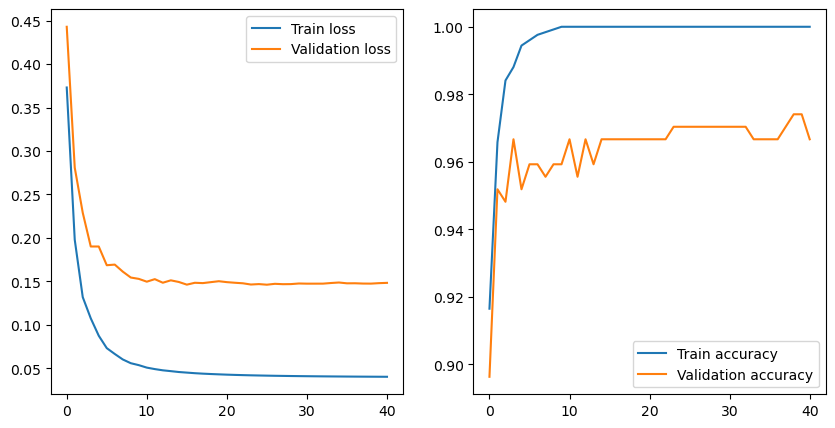

In [206]:
def train_MLP(model, X_train, y_train, X_val, y_val, 
              epochs = 500, patience = 15, lr = 1e-3, lr_decay = 0, 
              batch_size = 32, early_stopping = True):
    
    N = X_train.shape[0]   
    best_val_loss = np.inf
    counter = 0 # early stopping counter
    
    for epoch in range(epochs):
        perm = np.random.permutation(N)
        X_train, y_train = X_train[perm], y_train[perm]
           
        for start in range(0, N, batch_size):
            end = start + batch_size
            Xb = X_train[start:end]
            yb = y_train[start:end]
            model.backward(Xb, yb, lr) # forward, loss_grad, and backprop

        train_loss, _, _, _ = model.loss_and_grads(X_train, y_train)
        y_pred_train = model.predict(X_train)
        train_acc = np.mean(y_pred_train == y_train)

        val_loss, _, _, _ = model.loss_and_grads(X_val, y_val)
        y_pred_val = model.predict(X_val)
        val_acc = np.mean(y_pred_val == y_val)

        loss_train.append(train_loss)
        loss_val.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        ####### Report training and validation loss/accuracy every 10 epochs ########
        if epoch % 10 == 0:
            print(f"Epoch {epoch}:  "
                  f"Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, "
                  f"Val Acc={val_acc:.4f}")
        #############################################################################
        
        ##### Early stopping based on validation loss ##########
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if early_stopping and patience_counter >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break
        ########################################################
        
        lr = lr * (1.0 / (1.0 + lr_decay * epoch)) # update learning rate if decay_rate provided
        
           
loss_train = []
loss_val = [] 
train_accs = []
val_accs = [] 

m = myMLPClassifier(layer_size=[64, 128, 26, 10], activation = 'relu', l2 = 1e-4, momentum = 0.7)
train_MLP(m, X_train, y_train, X_val, y_val)

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(loss_train, label = 'Train loss')
ax[0].plot(loss_val, label  = 'Validation loss')
ax[0].legend()

ax[1].plot(train_accs, label = 'Train accuracy')
ax[1].plot(val_accs, label  = 'Validation accuracy')
ax[1].legend()
plt.show()



My MLP Test Acc = 0.9704
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        23
           2       0.96      1.00      0.98        27
           3       1.00      1.00      1.00        26
           4       0.96      0.92      0.94        26
           5       0.96      0.96      0.96        24
           6       1.00      0.96      0.98        24
           7       0.94      0.97      0.96        33
           8       0.94      1.00      0.97        30
           9       0.96      0.93      0.94        27

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270

Sklearn MLP Test Acc = 0.8815
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.63      0.83      0.72        23
           2       0.96

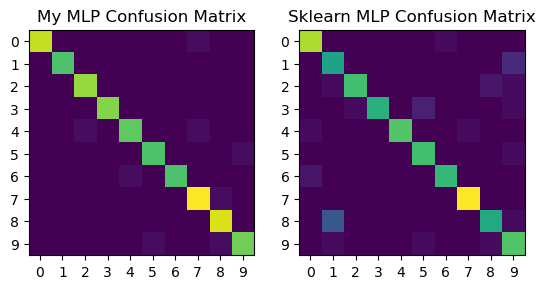

In [209]:
test_pred = m.predict(X_test)
test_acc = np.mean(test_pred == y_test)
print(f'My MLP Test Acc = {test_acc:.4f}')

fig, ax = plt.subplots(1,2)
print(classification_report(y_test, test_pred))
ax[0].imshow(confusion_matrix(y_test, test_pred))
ax[0].set_xticks(np.arange(0,10))
ax[0].set_yticks(np.arange(0,10))
ax[0].set_title('My MLP Confusion Matrix')
# ax[0].show_colorbar()


model = MLPClassifier([64, 128, 26, 10], activation = 'relu', solver = 'sgd', 
                      batch_size = 32, early_stopping = True, 
                      learning_rate = 'adaptive', alpha = 1e-4, momentum = 0.7)
model.fit(X_train, y_train)
test_pred_sklearn = model.predict(X_test)
test_acc_sklearn = np.mean(test_pred_sklearn == y_test)


print(f'Sklearn MLP Test Acc = {test_acc_sklearn:.4f}')
print(classification_report(y_test, test_pred_sklearn))
ax[1].imshow(confusion_matrix(y_test, test_pred_sklearn))
ax[1].set_xticks(np.arange(0,10))
ax[1].set_yticks(np.arange(0,10))
ax[1].set_title('Sklearn MLP Confusion Matrix')
# ax[1].colorbar()
# fig.show()
plt.show()
